## Imports & loading the row training data + test data
---

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

yamen_mac_data_folder_path = '/Users/yamenalkattab/Desktop/guthub/ieee-fraud-detection'
#yamen_data_folder_path = r'C:\Users\yamen\OneDrive\Desktop\DA151X KEX-arbete for DATA\kaggle\ieee-fraud-detection'
#oscar_data_folder_path = r''

data_folder_path = yamen_mac_data_folder_path

df_train_transaction = pd.read_csv(data_folder_path + '/train_transaction.csv')
#df_train_identity = pd.read_csv(your_data_folder_path + r'\train_identity.csv)

df_test_transaction = pd.read_csv(data_folder_path + '/test_transaction.csv')
#df_test_identity = pd.read_csv(your_data_folder_path + r'\test_identity.csv')

## data preprocessing functions
---

In [11]:
# pass in the data frame as an argument to change all boolean columns to binary with type int8 to occupy less memory
def encode_binary(df: pd.DataFrame, column_name):
    # Encode binary features T/F/NaN as 1/0/-1
    df[column_name] = df[column_name].map(lambda x: 1 if x=='T' else 0 if x=='F' else -1).astype('int8')
    return df[column_name]

# A pivvot table to be used in the object encoding functions. Diverse object columns EDA
def make_pivot(df:pd.DataFrame, index:str) -> pd.DataFrame:
    """..."""
    df[index] = df[index].fillna('NaN')
    df_pivot = df.pivot_table(index=index, columns='isFraud', aggfunc='size')
    df_pivot = df_pivot.fillna(0)
    df_pivot.columns = ['valid', 'fraud']
    df_pivot['count'] = df_pivot['valid'] + df_pivot['fraud']
    df_pivot[['valid_norm', 'fraud_norm']] = df_pivot[['valid', 'fraud']].div(other=df_pivot['count'], axis=0)
    df_pivot = df_pivot.sort_values(by='fraud_norm', ascending=False)
    return df_pivot

# works for columns with objects to be encoded as numerical (procudctCD, card4, card6, M4, P_emaildomain, R_emaildomain)
def encode_hierercical_fraud_rate(df: pd.DataFrame, column_name):
    temp_pivot = make_pivot(df, index=column_name)
    return df[column_name].map(temp_pivot['fraud_norm'])




## visulalizing functions & settings
---

In [16]:
# Define ANSI escape codes for colors
color_red = '\033[31m'
color_green = '\033[32m'
color_yellow = '\033[33m'
color_blue = '\033[34m'
color_magenta = '\033[35m'
color_cyan = '\033[36m'
color_reset = '\033[0m'  # Reset color to default

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
#df_train_transaction.describe()

def describe_whole_df(df):
    for col in df.columns:
        values = df_train_transaction[col]
        num_uniques = values.nunique()
        
        # Data type of the column
        data_type = values.dtype
        
        # Number of NaN values
        num_nan = values.isnull().sum()
        
        # Number of non-NaN values
        num_non_nan = values.count()
        
        # Ratio of NaN values
        if num_non_nan > 0:
            nan_ratio = num_nan / (num_nan + num_non_nan)
        else:
            nan_ratio = np.nan
        
        print(color_cyan + f'Column: {col}' + color_reset)
        print(color_yellow + f'Data Type: {data_type}'+ color_reset)
        print(color_magenta+ f'Number of Unique Values: {num_uniques}'+ color_reset)
        print(color_red+ f'Number of NaN Values: {num_nan}'+ color_reset)
        print(color_green+ f'Number of Non-NaN Values: {num_non_nan}'+ color_reset)
        print(color_blue+ f'Ratio of NaN Values: {nan_ratio:.4f}\n'+ color_reset)
        
        print(f'Unique Values:')
        print(values.unique())
        
        # Plotting example (optional)
        if num_uniques <= 10:  # Plot only if number of unique values is reasonable
            plt.figure(figsize=(8, 4))
            if pd.api.types.is_numeric_dtype(values):
                sns.histplot(values.dropna(), bins=20, kde=True)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
            else:
                value_counts = values.value_counts()
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.title(f'Bar plot of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
            plt.show()
        print('\n --------------------------------------------NEXT FEATURE---------------------------------------------\n')

def describe_df_with_columns(df,list_of_columns):
    for col in list_of_columns:
        values = df[col]
        num_uniques = values.nunique()
        if num_uniques <= 2:
            continue
        data_type = values.dtype
        num_nan = values.isnull().sum()
        num_non_nan = values.count()
        if num_non_nan > 0:
            nan_ratio = num_nan / (num_nan + num_non_nan)
        else:
            nan_ratio = np.nan
        print(color_cyan + f'Column: {col}' + color_reset)
        print(color_yellow + f'Data Type: {data_type}'+ color_reset)
        print(color_magenta+ f'Number of Unique Values: {num_uniques}'+ color_reset)
        print(color_red+ f'Number of NaN Values: {num_nan}'+ color_reset)
        print(color_green+ f'Number of Non-NaN Values: {num_non_nan}'+ color_reset)
        print(color_blue+ f'Ratio of NaN Values: {nan_ratio:.4f}\n'+ color_reset)
        print(f'Unique Values:')
        print(values.unique())
        if num_uniques <= 10:  # Plot only if number of unique values is reasonable
            plt.figure(figsize=(8, 4))
            if pd.api.types.is_numeric_dtype(values):
                sns.histplot(values.dropna(), bins=100, kde=True)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
            else:
                value_counts = values.value_counts()
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.title(f'Bar plot of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
            plt.show()
        print('\n --------------------------------------------NEXT FEATURE---------------------------------------------\n')

## TEMP 

In [12]:
df_train_transaction_pp = df_train_transaction.copy()

binary_object_columns = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'] # M1-M3, M5-M9, encode as 0/1 for False/True
for col in binary_object_columns:
    df_train_transaction_pp[col] = encode_binary(df_train_transaction_pp, col)

diverse_object_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4']
for col in diverse_object_columns:
    df_train_transaction_pp[col] = encode_hierercical_fraud_rate(df_train_transaction_pp, col)


In [13]:
df_train_transaction_pp[binary_object_columns].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   M1      590540 non-null  int8 
 1   M2      590540 non-null  int8 
 2   M3      590540 non-null  int8 
 3   M5      590540 non-null  int8 
 4   M6      590540 non-null  int8 
 5   M7      590540 non-null  int8 
 6   M8      590540 non-null  int8 
 7   M9      590540 non-null  int8 
dtypes: int8(8)
memory usage: 4.5 MB


In [14]:
df_train_transaction_pp[diverse_object_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ProductCD      590540 non-null  float64
 1   card4          590540 non-null  float64
 2   card6          590540 non-null  float64
 3   P_emaildomain  590540 non-null  float64
 4   R_emaildomain  590540 non-null  float64
 5   M4             590540 non-null  float64
dtypes: float64(6)
memory usage: 27.0 MB


Column: ProductCD
Data Type: float64
Number of Unique Values: 5
Number of NaN Values: 0
Number of Non-NaN Values: 590540
Ratio of NaN Values: 0.0000

Unique Values:
[0.02039939 0.04766231 0.11687269 0.05899553 0.03782594]


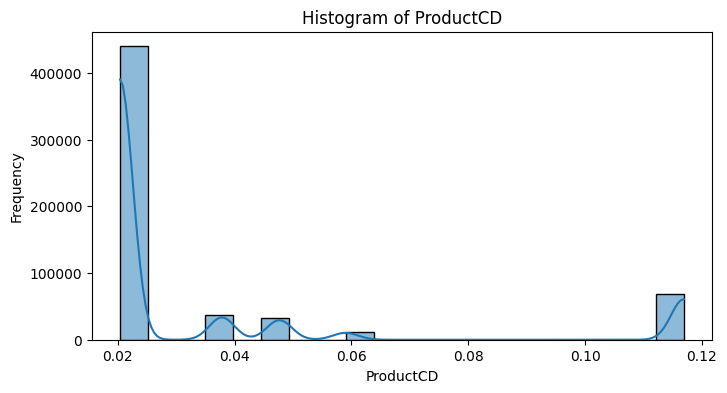


 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: card4
Data Type: float64
Number of Unique Values: 5
Number of NaN Values: 0
Number of Non-NaN Values: 590540
Ratio of NaN Values: 0.0000

Unique Values:
[0.07728161 0.03433095 0.0347561  0.02869837 0.02599873]


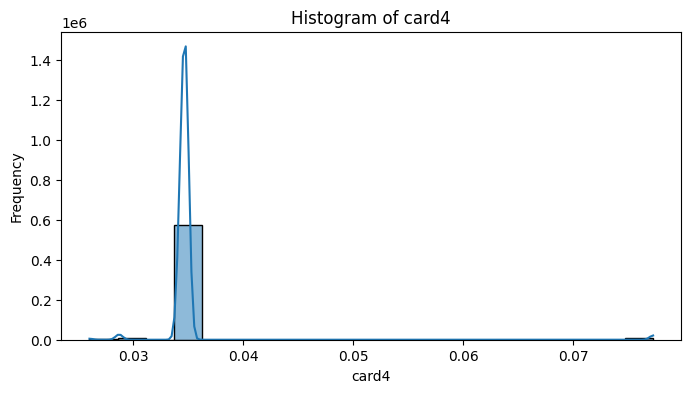


 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: card6
Data Type: float64
Number of Unique Values: 4
Number of NaN Values: 0
Number of Non-NaN Values: 590540
Ratio of NaN Values: 0.0000

Unique Values:
[0.0667848  0.02426251 0.02482495 0.        ]


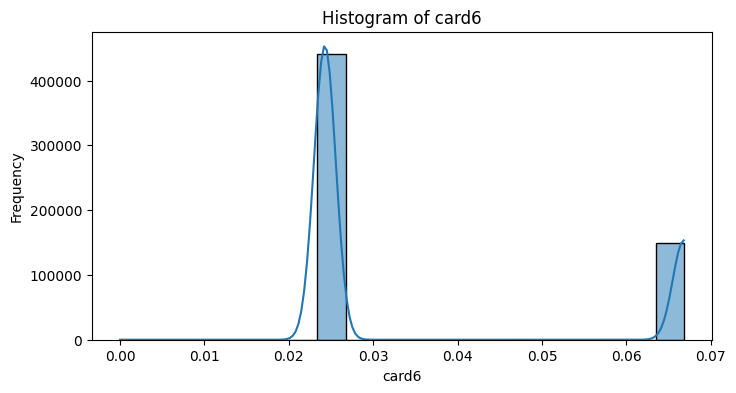


 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: P_emaildomain
Data Type: float64
Number of Unique Values: 44
Number of NaN Values: 0
Number of Non-NaN Values: 590540
Ratio of NaN Values: 0.0000

Unique Values:
[0.02953756 0.04354185 0.09458399 0.02275745 0.18962433 0.02321747
 0.05295028 0.00813309 0.0218106  0.01773982 0.03118661 0.01681503
 0.02081838 0.03063725 0.00301205 0.00483092 0.03461538 0.0314345
 0.05473965 0.02217742 0.02762249 0.00743863 0.01863354 0.02086811
 0.0040404  0.02776323 0.02199413 0.         0.01036941 0.02140078
 0.06557377 0.00983607 0.00510204 0.02285714 0.02564103 0.02857143
 0.13013699 0.03211009 0.12698413 0.01886792 0.03496503 0.01492537
 0.00609756 0.40789474]

 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: R_emaildomain
Data Type: float64
Number of Unique Values: 34
Number of NaN Values: 0
Number of Non-NaN Values: 590540
Ra

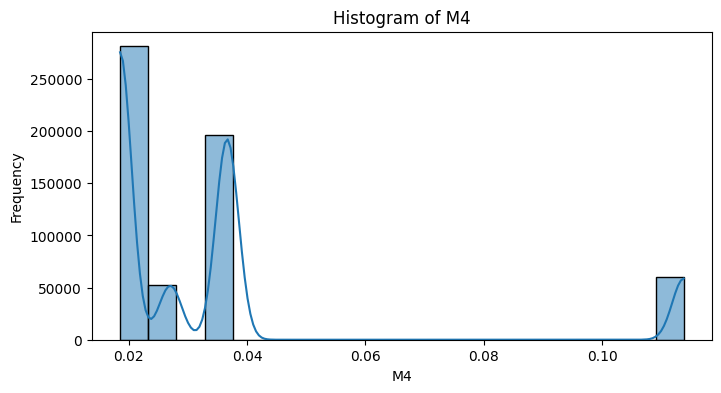


 --------------------------------------------NEXT FEATURE---------------------------------------------



In [18]:
df_categorical = df_train_transaction.select_dtypes(include=[object])



describe_df_with_columns(df_train_transaction_pp,diverse_object_columns)
